In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import shap

import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['forest_cover_data.csv']))
df.head()


Saving forest_cover_data.csv to forest_cover_data.csv


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


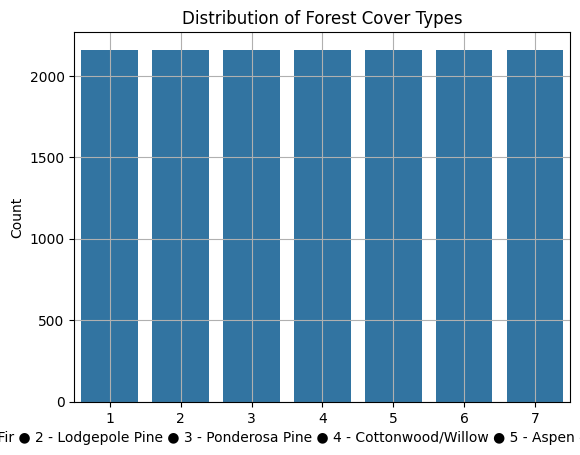

In [5]:
sns.countplot(x='Cover_Type', data=df)
plt.title("Distribution of Forest Cover Types")
plt.xlabel("Cover Type (● 1- Spruce/Fir ● 2 - Lodgepole Pine ● 3 - Ponderosa Pine ● 4 - Cottonwood/Willow ● 5 - Aspen ● 6 - Douglas-fir ● 7 - Krummholz)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


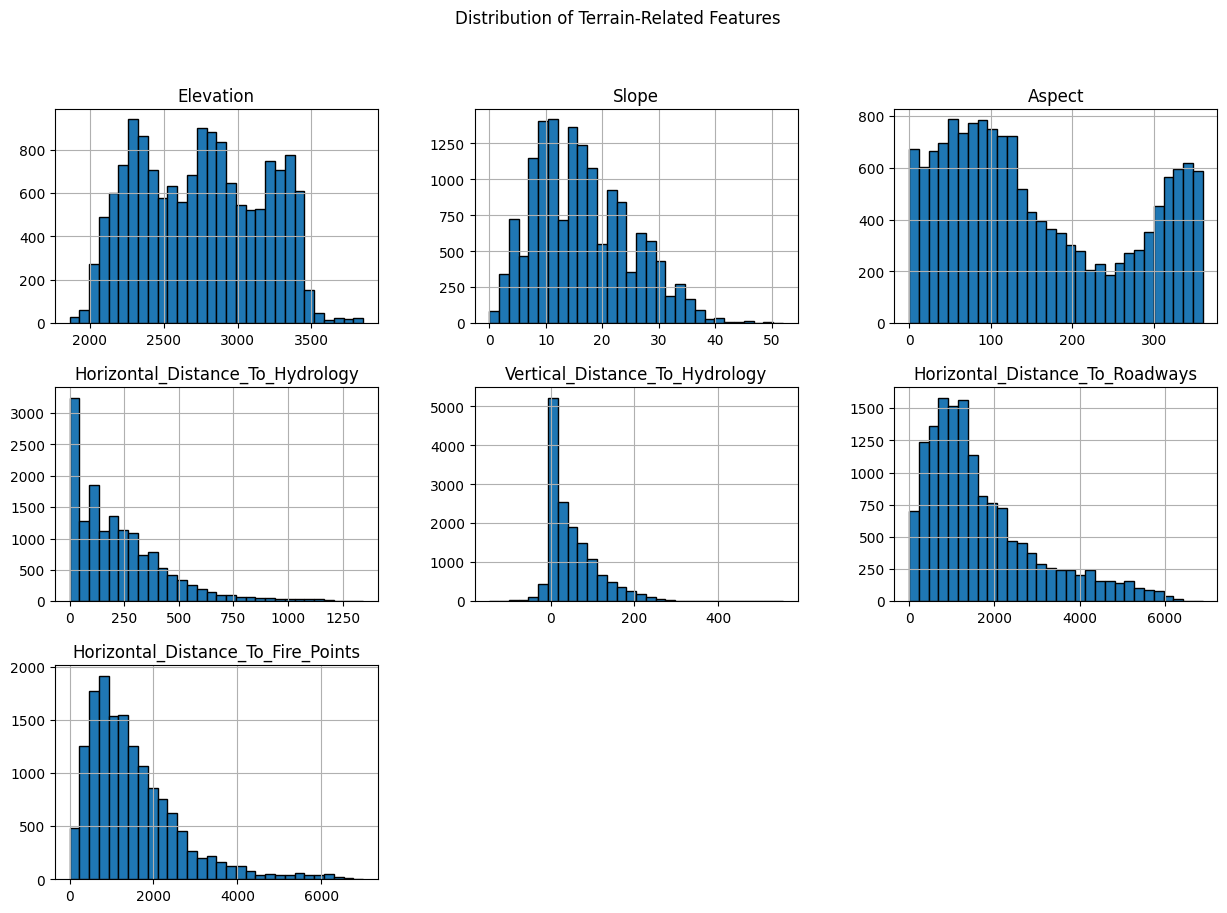

In [6]:
numeric_cols = ['Elevation', 'Slope', 'Aspect', 'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Horizontal_Distance_To_Fire_Points']

df[numeric_cols].hist(bins=30, figsize=(15,10), edgecolor='black')
plt.suptitle("Distribution of Terrain-Related Features")
plt.show()


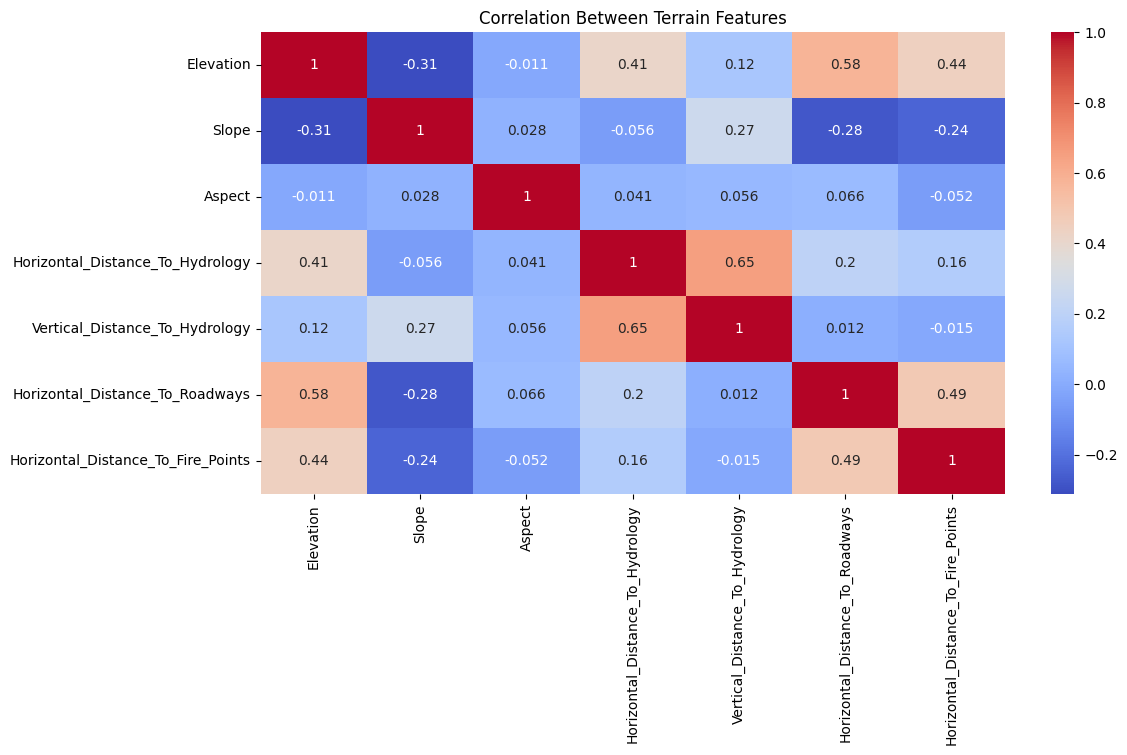

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Terrain Features")
plt.show()


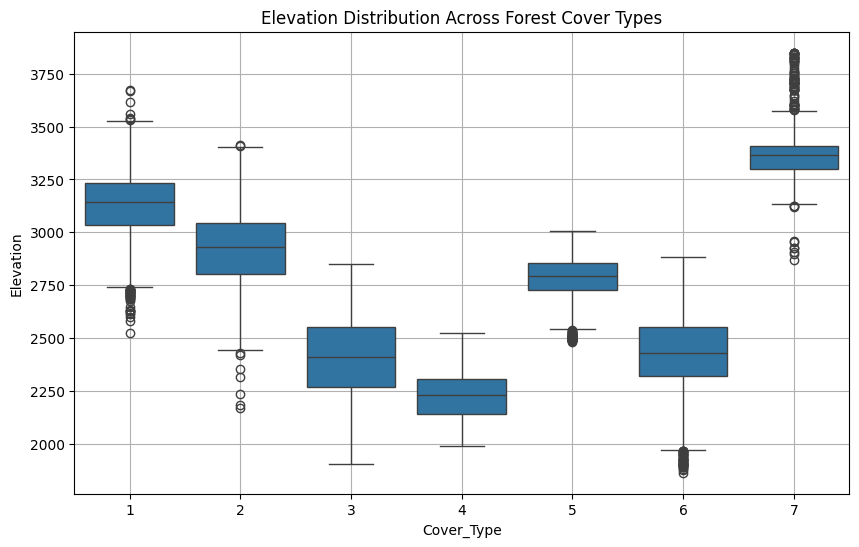

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Cover_Type', y='Elevation', data=df)
plt.title("Elevation Distribution Across Forest Cover Types")
plt.grid(True)
plt.show()


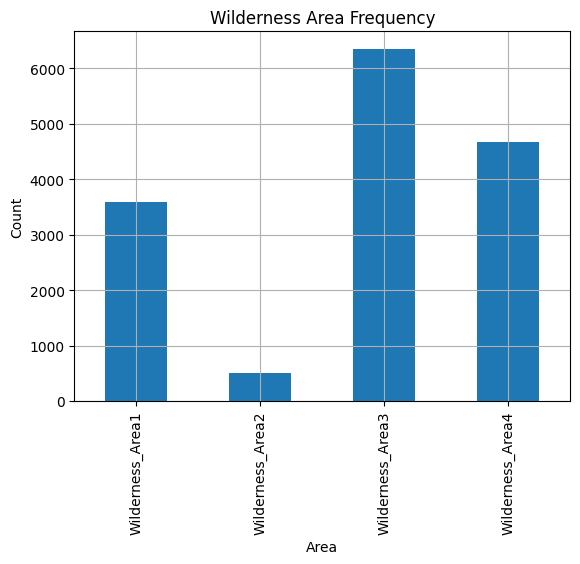

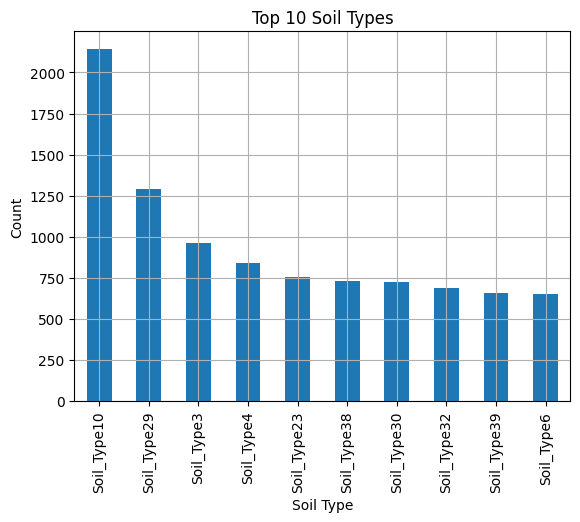

In [9]:
# Wilderness Area
wilderness_cols = [col for col in df.columns if 'Wilderness_Area' in col]
wilderness_sum = df[wilderness_cols].sum()
wilderness_sum.plot(kind='bar', title="Wilderness Area Frequency", xlabel="Area", ylabel="Count")
plt.grid(True)
plt.show()

# Soil Types
soil_cols = [col for col in df.columns if 'Soil_Type' in col]
soil_sum = df[soil_cols].sum().sort_values(ascending=False)
soil_sum[:10].plot(kind='bar', title="Top 10 Soil Types", xlabel="Soil Type", ylabel="Count")
plt.grid(True)
plt.show()


Shape: (15120, 56)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-nu

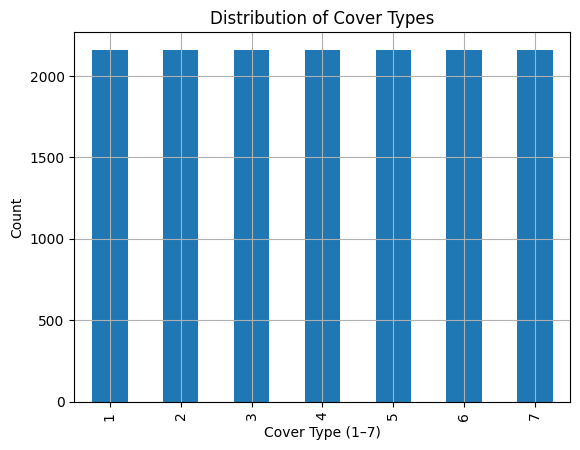

In [10]:
print("Shape:", df.shape)
df.info()
df.describe()
df['Cover_Type'].value_counts().sort_index().plot(kind='bar', title="Distribution of Cover Types")
plt.xlabel("Cover Type (1–7)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [11]:
print("Null values:\n", df.isnull().sum())
print("\nUnique values in Soil Types:", df.filter(like='Soil_Type').nunique().sum())
print("Unique values in Wilderness Areas:", df.filter(like='Wilderness_Area').nunique().sum())


Null values:
 Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10               

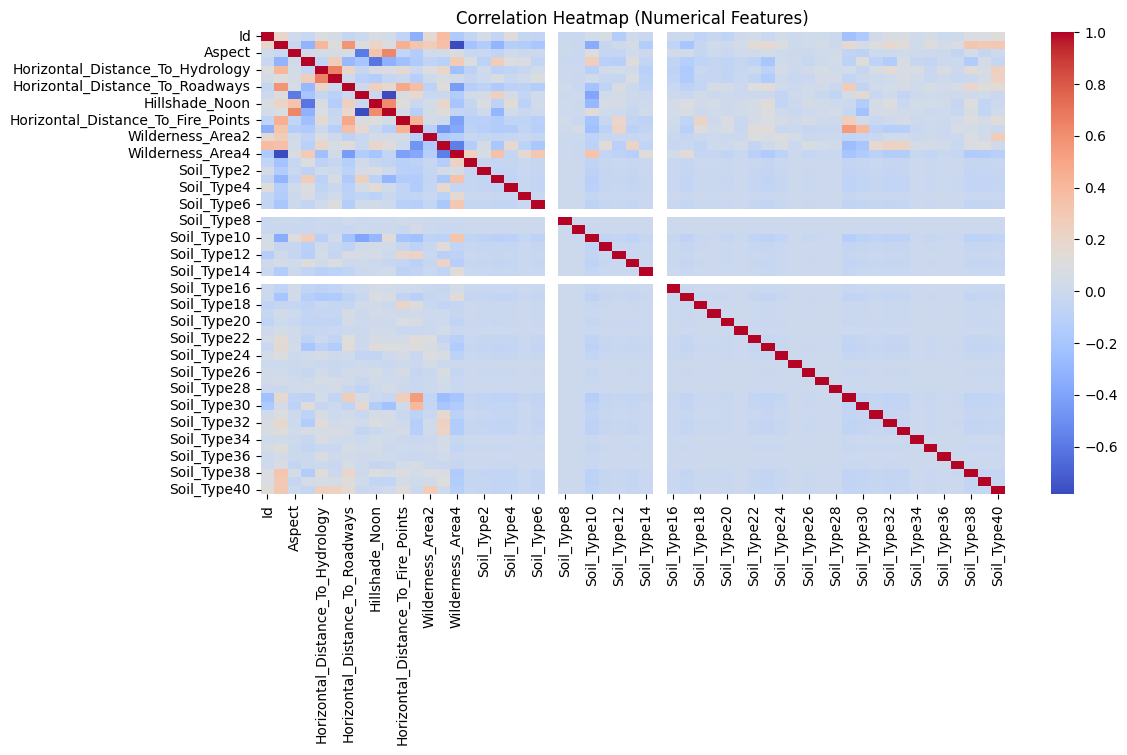

In [12]:

numeric_cols = df.select_dtypes(include=np.number).drop(columns=['Cover_Type'])
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [13]:
X = df.drop(columns='Cover_Type')
y = df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)




In [18]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.8657407407407407


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("Random Forest CV Accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Random Forest CV Accuracy: 0.8723 ± 0.0044
